In [5]:
%pylab inline
import numpy as np
from parametric_pde_find import *
from scipy.integrate import odeint
from numpy.fft import fft, ifft, fftfreq
from time import time
import threshold_BGLSS
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
from scipy import signal
import scipy.signal

fontsize = 20

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/yifan/miniconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['fft', 'copy', 'time']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [6]:
importlib.reload(threshold_BGLSS)
from threshold_BGLSS import *

## Define the PDE

In [13]:
def parametric_advection_rhs(u, t, params):
    k,c,dx = params
    art_visc = 1e-2
    cond1=c>0.0
    cond2=c<=0.0
    rhs = 0.0*u
    rhs[cond2] = -c[cond2]*(np.roll(u,-1)[cond2]-u[cond2])/dx
    rhs[cond1] = -c[cond1]*(u[cond1] - np.roll(u,1)[cond1])/dx
    return rhs

## Solve the PDE

In [16]:
# Set size of grid
n = 256
m = 256

# Set up grid
x = np.linspace(-5,5,n+1)[:-1];   dx = x[1]-x[0]
t = np.linspace(0,5,m);          dt = t[1]-t[0]
k = 2*np.pi*fftfreq(n, d = dx)

# Initial condition
u0 = np.exp(-(x)**2/2**2)
c = np.zeros(x.shape)
c[x<0] =-1.0
c[x>=0] =1.0

# Solve with time dependent uu_x term
params = (k, c,dx)
u = odeint(parametric_advection_rhs, u0, t, args=(params,)).T

u_x_true = np.copy(c)

/tmp/ipykernel_61606/2049074070.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcolor(X, T, u.T, cmap=cm.coolwarm)


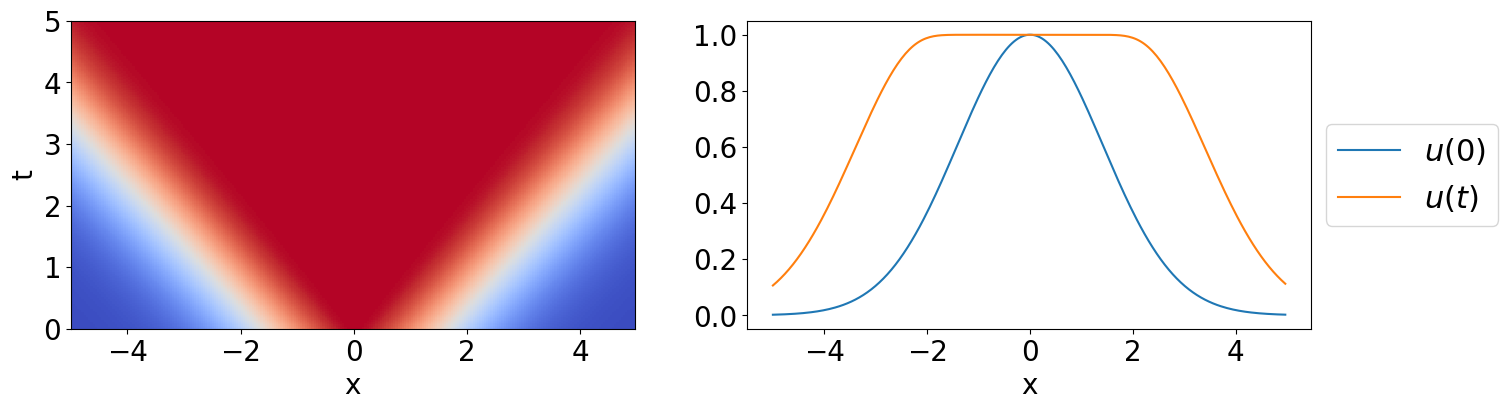

In [17]:
# Plot
fig=figure(figsize=(16,4))
X, T = np.meshgrid(x, t)

subplot(1,2,1)
pcolor(X, T, u.T, cmap=cm.coolwarm)
xlabel('x', fontsize = fontsize)
ylabel('t', fontsize = fontsize)
xticks(fontsize = fontsize)
yticks(fontsize = fontsize)
xlim([x[0],x[-1]])

subplot(1,2,2)
plot(x, u[:,0], label=r'$u(0)$')
plot(x, u[:,100], label=r'$u(t)$')

xticks(fontsize = fontsize)
yticks(fontsize = fontsize)
xlabel('x', fontsize = fontsize)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = fontsize+2)
# fig.tight_layout()

## Build the Regression Model

In [309]:
Ut, Theta, rhs_des = build_linear_system(u, dt, dx, D=4, P=3, time_diff = 'FD', space_diff = 'FD')

In [310]:
Theta_grouped = [real(Theta[j*n:(j+1)*n,:]) for j in range(m)]
Ut_grouped = [real(Ut[j*n:(j+1)*n]) for j in range(m)]
Xs = Theta_grouped
ys = Ut_grouped

In [311]:
print(Ut.shape)
print(Theta.shape)
print(rhs_des)

(65536, 1)
(65536, 20)
['', 'u', 'u^2', 'u^3', 'u_{x}', 'uu_{x}', 'u^2u_{x}', 'u^3u_{x}', 'u_{xx}', 'uu_{xx}', 'u^2u_{xx}', 'u^3u_{xx}', 'u_{xxx}', 'uu_{xxx}', 'u^2u_{xxx}', 'u^3u_{xxx}', 'u_{xxxx}', 'uu_{xxxx}', 'u^2u_{xxxx}', 'u^3u_{xxxx}']


In [312]:
#i_uu_x = [i for i in range(len(rhs_des)) if rhs_des[i] == 'uu_{x}'][0]
#i_u_xx = [i for i in range(len(rhs_des)) if rhs_des[i] == 'u_{xx}'][0]
i_u_x = [i for i in range(len(rhs_des)) if rhs_des[i] == 'u_{x}'][0]
xi_true = np.zeros((20, 256))
xi_true[i_u_x] = u_x_true

In [318]:
print(xi_true[:,200])

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [319]:
un = u + 0.01*np.std(u)*np.random.randn(n,m)

In [320]:
# Build linear systems
wx = 10 
wt = 10 

Utn, Thetan, rhs_des = build_linear_system(un, dt, dx, D=4, P=3, time_diff = 'poly',
                                       deg_x = 6, deg_t = 4, 
                                       width_x = wx, width_t = wt)
n2 = n - 2*wx
m2 = m - 2*wt

In [275]:
# Group by timestep
Thetan_grouped = [real(Thetan[j*n2:(j+1)*n2,:]) for j in range(m2)]
Utn_grouped = [real(Utn[j*n2:(j+1)*n2]) for j in range(m2)]

/tmp/ipykernel_38046/4203270816.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcolor(X, T, un.T-u.T, cmap=cm.coolwarm)


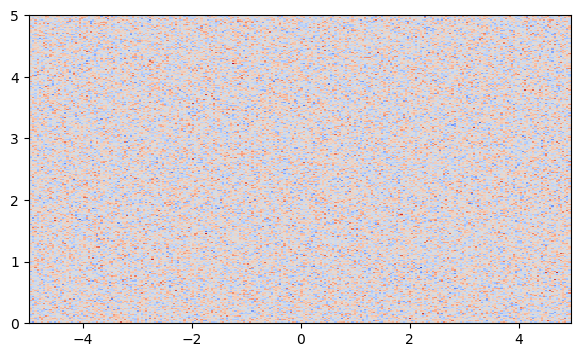

In [276]:
pcolor(X, T, un.T-u.T, cmap=cm.coolwarm)

In [277]:
def movingaverage(values, window):
    weights = np.repeat(1.0, window)/window
    sma = np.convolve(values, weights, 'valid')
    return sma

In [278]:
from scipy import signal

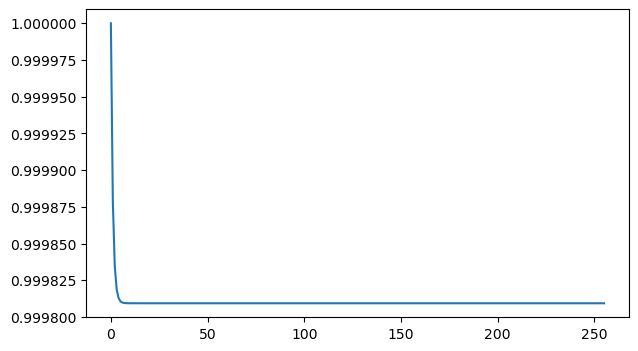

In [279]:
plot(u[128, :])

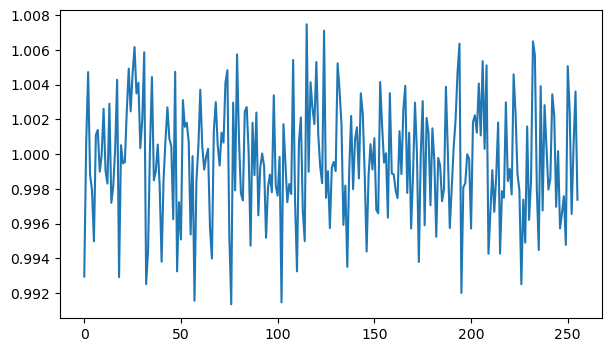

In [280]:
plot(un[128, :])

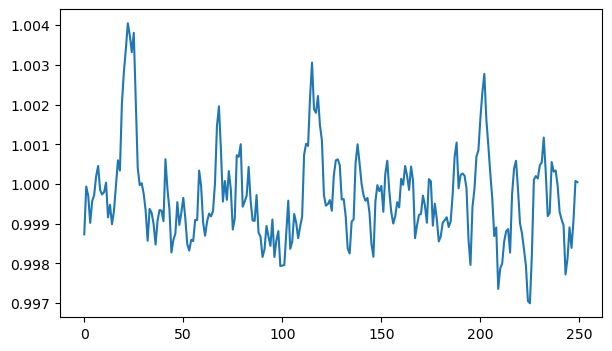

In [281]:
plot(movingaverage(un[128, :], 7))

In [282]:
b, a = scipy.signal.butter(3, 0.2)

In [283]:
y = scipy.signal.filtfilt(b, a, un[128, :])

1.099698457297275e-05
1.963498519247145e-06


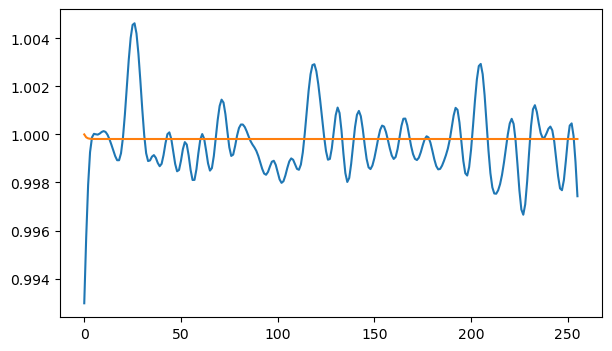

In [284]:
plot(y)
plot(u[128, :])
print(np.mean(np.square(un[128, :] - u[128, :])))
print(np.mean(np.square(y - u[128, :])))

## Flitflit

In [285]:
mse = []
interval = np.linspace(0.05, 0.5, num = 101)
for cut in interval:
    b, a = scipy.signal.butter(3, cut)
    uff = np.zeros(un.shape)
    for i in range(uff.shape[0]):
        uff[i, :] = scipy.signal.filtfilt(b, a, un[i, :])
    mse.append(np.mean(np.square(uff-u)))

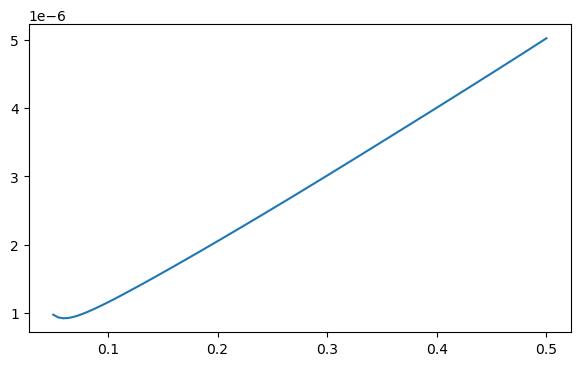

In [286]:
plot(interval, mse)

In [287]:
interval[np.argmin(mse)]

0.059000000000000004

In [288]:
mse[np.argmin(mse)]

9.2159446679674e-07

In [289]:
cut = 0.0725

In [290]:
b, a = scipy.signal.butter(3, cut)
uff = np.zeros(un.shape)
for i in range(uff.shape[0]):
    uff[i, :] = scipy.signal.filtfilt(b, a, un[i, :])

In [291]:
np.mean(np.square(un-u))

1.0934689239821855e-05

In [292]:
np.mean(np.square(uff-u))

9.610081989852654e-07

In [293]:
res = uff-u

/tmp/ipykernel_38046/506537243.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcolor(X, T, res.T, cmap=cm.coolwarm)


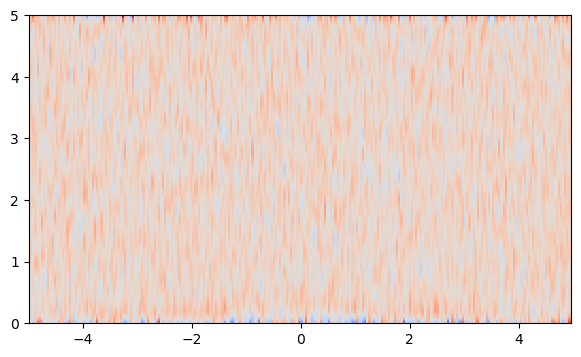

In [295]:
pcolor(X, T, res.T, cmap=cm.coolwarm)

In [296]:
# Build linear systems
wx = 10 
wt = 10 

Utff, Thetaff, rhs_des = build_linear_system(uff, dt, dx, D=4, P=3, time_diff = 'poly',
                                       deg_x = 6, deg_t = 4, 
                                       width_x = wx, width_t = wt)
n2 = n - 2*wx
m2 = m - 2*wt

In [297]:
# Group by timestep
Thetaff_grouped = [real(Thetaff[j*n2:(j+1)*n2,:]) for j in range(m2)]
Utff_grouped = [real(Utff[j*n2:(j+1)*n2]) for j in range(m2)]

In [298]:
xi_ff, lam_ff, loss_ff, path_ff, coef_ff, remain_ff = thresholdBGLSS_combined(Thetaff_grouped, Utff_grouped, niter = 600, burnin = 100, threshold1 = 0.01, threshold2 = 0.02)

0
20
Update:
0
Lambda2:
1.1628043798519683

Update:
1
Lambda2:
1.300998770796841

Update:
2
Lambda2:
1.434214089386441

Update:
3
Lambda2:
1.5719465108901536

Update:
4
Lambda2:
1.700709983564063

Update:
5
Lambda2:
1.8298485953498664

Update:
6
Lambda2:
1.9620358738335686

Update:
7
Lambda2:
2.0799434178884604

Update:
8
Lambda2:
2.1995741747127298

Update:
9
Lambda2:
2.3154255749243653

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
17

/home/yifan/Documents/code_equation_learn/Experiments/threshold_BGLSS.py:206: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  candidate_norms[i] = Norm(np.vstack(A[:,i] for A in As), loss_normalize)
/home/yifan/Documents/code_equation_learn/Experiments/threshold_BGLSS.py:23: RuntimeWarning: invalid value encountered in divide
  rate = np.sum(variance, axis=1)/np.sum(mean**2, axis=1)


GE: 
[0.00708796        nan 0.00788837        nan        nan        nan
        nan        nan 0.04102757        nan        nan 0.07387419
        nan        nan        nan        nan 0.03710543        nan
        nan        nan]
[0, 2]
0
2
Update:
0
Lambda2:
4.257062126763135

Update:
1
Lambda2:
6.779865314006573

Update:
2
Lambda2:
7.761937419432125

Update:
3
Lambda2:
7.902039270889656

Update:
4
Lambda2:
7.62528915512598

Update:
5
Lambda2:
7.342724905607391

Update:
6
Lambda2:
7.0362623724433595

Update:
7
Lambda2:
6.677823896761696

Update:
8
Lambda2:
6.429760588153436

Update:
9
Lambda2:
6.246719235060753

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
1

In [299]:
remain_ff

[0, 2]

In [300]:
std_ff = np.std(coef_ff, axis=1, ddof=1).reshape(m2,xi_ff.shape[0]).T

MSE:  0.08285260977982849


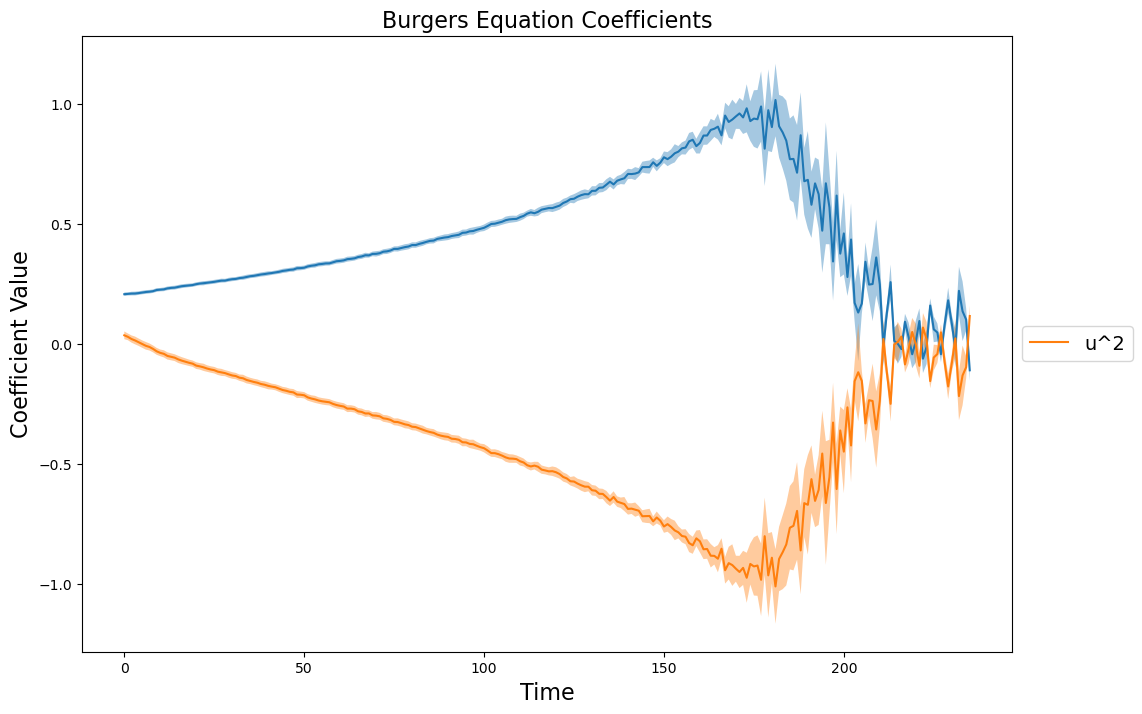

In [301]:
xi = xi_ff
remain = remain_ff
std = std_ff

xi_bglss = np.zeros(xi_true[:,wt:-wt].shape)

pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi.shape[0]): 
    if np.linalg.norm(xi[j,:]) > 10**-10:
        plot(xi[j,:], label = rhs_des[remain[j]])
        fill_between(range(len(xi[j,:])), xi[j,:]-std[j, :], xi[j,:]+std[j, :], alpha=0.4)
        xi_bglss[remain[j], :] = xi[j,:]

title('Burgers Equation Coefficients', fontsize = 16)
xlabel('Time', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)

mse_ff_bglss = Norm(xi_bglss-xi_true[:,wt:-wt])**2/(m2*len(rhs_des))
print('MSE: ', mse_ff_bglss)

## Savgol Filter

In [37]:
mse = []
for window in range(5, 52, 2):
    usf = np.zeros(un.shape)
    for i in range(usf.shape[0]):
        usf[i, :] = signal.savgol_filter(un[i, :], window, 3)
    mse.append(np.mean(np.square(usf-u)))

In [38]:
windows = list(range(5, 52, 2))
windows[np.argmin(mse)]

37

In [39]:
mse[np.argmin(mse)]

6.3663567653428725e-06

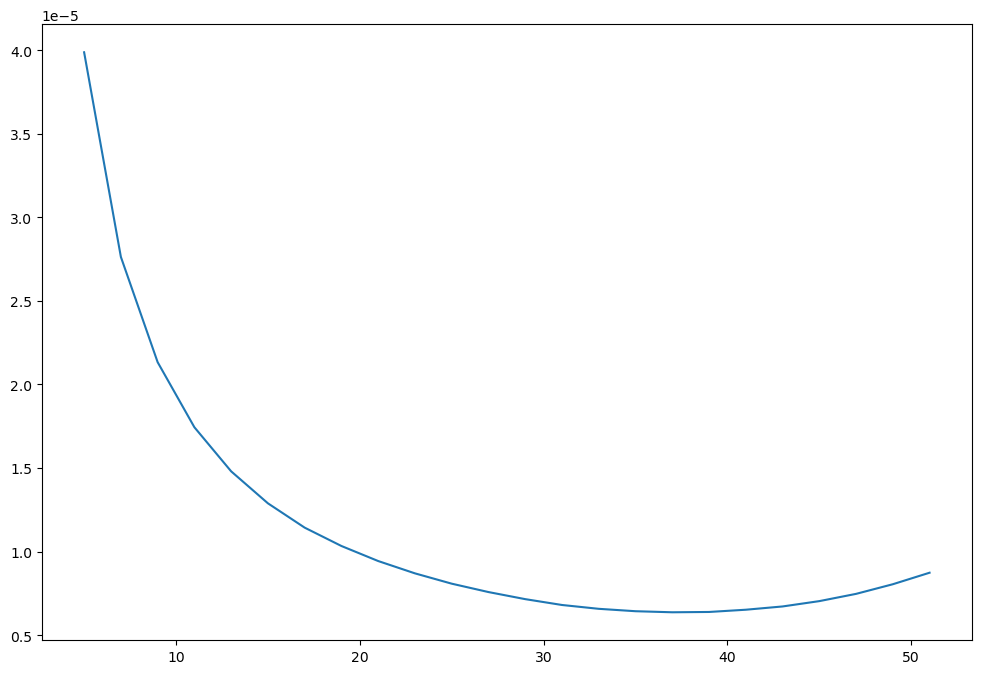

In [40]:
plot(windows, mse)

In [41]:
usf = np.zeros(un.shape)

In [42]:
window = 37

In [43]:
for i in range(usf.shape[0]):
    usf[i, :] = signal.savgol_filter(un[i, :], window, 3)

In [44]:
np.mean(np.square(usf-u))

6.3663567653428725e-06

In [45]:
res = usf-u

/tmp/ipykernel_38046/506537243.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcolor(X, T, res.T, cmap=cm.coolwarm)


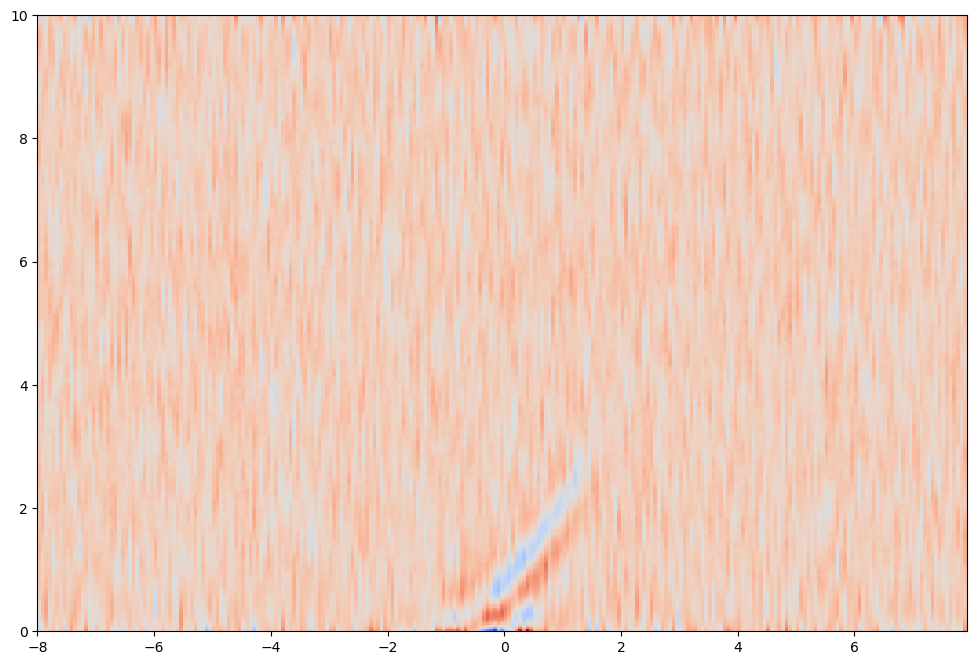

In [46]:
pcolor(X, T, res.T, cmap=cm.coolwarm)

In [47]:
# Build linear systems
wx = 10 
wt = 10 

Utsf, Thetasf, rhs_des = build_linear_system(usf, dt, dx, D=4, P=3, time_diff = 'poly',
                                       deg_x = 6, deg_t = 4, 
                                       width_x = wx, width_t = wt)
n2 = n - 2*wx
m2 = m - 2*wt

In [48]:
# Group by timestep
Thetasf_grouped = [real(Thetasf[j*n2:(j+1)*n2,:]) for j in range(m2)]
Utsf_grouped = [real(Utsf[j*n2:(j+1)*n2]) for j in range(m2)]

In [49]:
xi_sf, lam_sf, loss_sf, path_sf, coef_sf, remain_sf = thresholdBGLSS_combined(Thetasf_grouped, Utsf_grouped, niter = 600, burnin = 100, threshold1 = 0.01, threshold2 = 0.03)

0
20
Update:
0
Lambda2:
0.9211453227168126

Update:
1
Lambda2:
0.8146765542678166

Update:
2
Lambda2:
0.7247921318750513

Update:
3
Lambda2:
0.6586318078567052

Update:
4
Lambda2:
0.6073383473775772

Update:
5
Lambda2:
0.5654333718116664

Update:
6
Lambda2:
0.5371099260336494

Update:
7
Lambda2:
0.5140765823083604

Update:
8
Lambda2:
0.4928722336322041

Update:
9
Lambda2:
0.47873351362870936

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
17

/home/yifan/Documents/code_equation_learn/Experiments/threshold_BGLSS.py:206: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  candidate_norms[i] = Norm(np.vstack(A[:,i] for A in As), loss_normalize)
/home/yifan/Documents/code_equation_learn/Experiments/threshold_BGLSS.py:23: RuntimeWarning: invalid value encountered in divide
  rate = np.sum(variance, axis=1)/np.sum(mean**2, axis=1)


GE: 
[0.12384013 0.0332911         nan 0.02151684 0.01306565 0.01179233
        nan 0.66837739 0.01429681        nan        nan        nan
        nan        nan        nan 0.28144078        nan        nan
        nan        nan]
[3, 4, 5, 8]
0
4
Update:
0
Lambda2:
0.6634338802925783

Update:
1
Lambda2:
0.4836222278730737

Update:
2
Lambda2:
0.4060047293531896

Update:
3
Lambda2:
0.37621313117106747

Update:
4
Lambda2:
0.35633011502656226

Update:
5
Lambda2:
0.3462849350140489

Update:
6
Lambda2:
0.34444841100944895

Update:
7
Lambda2:
0.34135724585974075

Update:
8
Lambda2:
0.3387894076351609

Update:
9
Lambda2:
0.3370130498380592

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
1

In [50]:
remain_sf

[5, 8]

In [51]:
std_sf = np.std(coef_sf, axis=1, ddof=1).reshape(m2,xi_sf.shape[0]).T

MSE:  6.241248105156276e-05


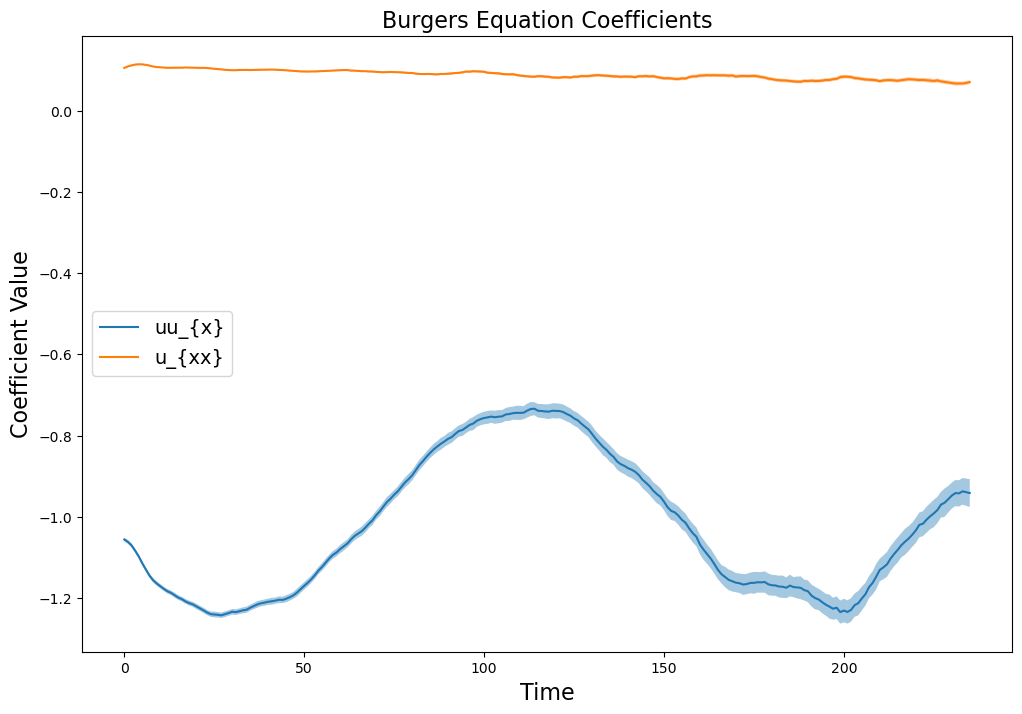

In [52]:
xi = xi_sf
remain = remain_sf
std = std_sf

xi_bglss = np.zeros(xi_true[:,wt:-wt].shape)

pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi.shape[0]): 
    if np.linalg.norm(xi[j,:]) > 10**-10:
        plot(xi[j,:], label = rhs_des[remain[j]])
        fill_between(range(len(xi[j,:])), xi[j,:]-std[j, :], xi[j,:]+std[j, :], alpha=0.4)
        xi_bglss[remain[j], :] = xi[j,:]

title('Burgers Equation Coefficients', fontsize = 16)
xlabel('Time', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', fontsize = 14)

mse_sf_bglss = Norm(xi_bglss-xi_true[:,wt:-wt])**2/(m2*len(rhs_des))
print('MSE: ', mse_sf_bglss)

## Moving Average

In [53]:
mse = []
for window in range(3, 21, 2):
    m_new = un.shape[1] - window + 1
    uma = np.zeros([un.shape[0], m_new])
    gap = int((window-1)/2)
    for i in range(uma.shape[0]):
        uma[i, :] = movingaverage(un[i, :], window)
    mse.append(np.mean(np.square(uma-u[:, gap:-gap])))

In [54]:
windows = list(range(3, 21, 2))
windows[np.argmin(mse)]

13

In [55]:
len(windows)

9

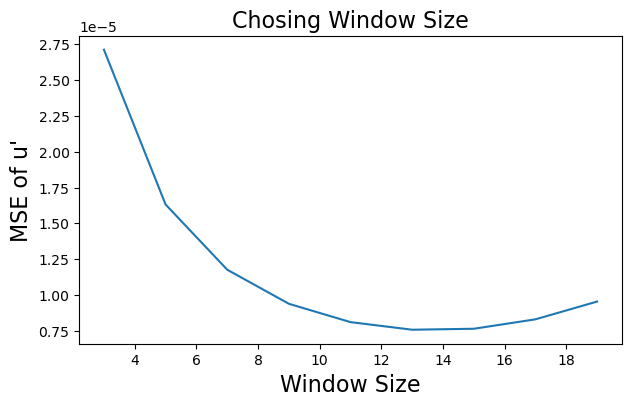

In [56]:
pylab.rcParams['figure.figsize'] = (7, 4)
fig, ax = plt.subplots()
plot(windows, mse)
ax.yaxis.get_major_formatter().set_powerlimits((0,1))
title('Chosing Window Size', fontsize = 16)
xlabel('Window Size', fontsize = 16)
ylabel('MSE of u\'', fontsize = 16)
fig.savefig("windows-MSE", dpi=200)

In [57]:
np.mean(np.square(un-u))

8.07701763619104e-05

In [58]:
window = 13
m_new = un.shape[1] - window + 1
uma = np.zeros([un.shape[0], m_new])

In [59]:
gap = int((window-1)/2)

In [60]:
for i in range(uma.shape[0]):
    uma[i, :] = movingaverage(un[i, :], window)

In [61]:
np.mean(np.square(uma-u[:, gap:-gap]))

7.57350348748482e-06

In [62]:
X2, T2 = np.meshgrid(x, t[gap:-gap])

In [63]:
res = uma-u[:, gap:-gap]

/tmp/ipykernel_38046/3360805101.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcolor(X2, T2, res.T, cmap=cm.coolwarm)


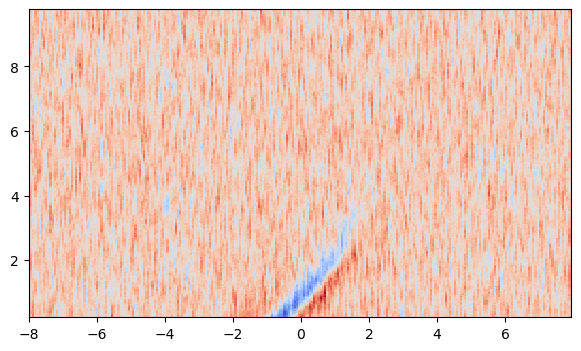

In [64]:
pcolor(X2, T2, res.T, cmap=cm.coolwarm)

In [65]:
# Build linear systems
wx = 10 
wt = 10 

Utma, Thetama, rhs_des = build_linear_system(uma, dt, dx, D=4, P=3, time_diff = 'poly',
                                       deg_x = 6, deg_t = 4, 
                                       width_x = wx, width_t = wt)
n3 = n - 2*wx
m3 = m - 2*wt - window + 1

In [66]:
# Group by timestep
Thetama_grouped = [real(Thetama[j*n3:(j+1)*n3,:]) for j in range(m3)]
Utma_grouped = [real(Utma[j*n3:(j+1)*n3]) for j in range(m3)]

In [67]:
xi_ma, lam_ma, loss_ma, path_ma, coef_ma, remain_ma = thresholdBGLSS_combined(Thetama_grouped, Utma_grouped, niter = 600, burnin = 100, threshold1 = 0.01, threshold2 = 0.03)

0
20
Update:
0
Lambda2:
0.978004725826294

Update:
1
Lambda2:
0.924415320567181

Update:
2
Lambda2:
0.8675688628955449

Update:
3
Lambda2:
0.8275310233566567

Update:
4
Lambda2:
0.7891974555191981

Update:
5
Lambda2:
0.7630628157665051

Update:
6
Lambda2:
0.739881993913467

Update:
7
Lambda2:
0.7234881896043593

Update:
8
Lambda2:
0.7099211165287711

Update:
9
Lambda2:
0.6962208830940548

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
17

/home/yifan/Documents/code_equation_learn/Experiments/threshold_BGLSS.py:206: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  candidate_norms[i] = Norm(np.vstack(A[:,i] for A in As), loss_normalize)
/home/yifan/Documents/code_equation_learn/Experiments/threshold_BGLSS.py:23: RuntimeWarning: invalid value encountered in divide
  rate = np.sum(variance, axis=1)/np.sum(mean**2, axis=1)


GE: 
[0.15467029 0.05308886        nan 0.02965894 0.01864796 0.03230587
 1.71729877 0.93739902 0.02353549        nan        nan        nan
        nan        nan        nan 0.43787567        nan        nan
        nan        nan]
[3, 4, 8]
0
3
Update:
0
Lambda2:
1.384876326424015

Update:
1
Lambda2:
1.627561595863316

Update:
2
Lambda2:
1.7690929510416524

Update:
3
Lambda2:
1.8377275848901826

Update:
4
Lambda2:
1.8823379030506266

Update:
5
Lambda2:
1.884886947752771

Update:
6
Lambda2:
1.9108303775613553

Update:
7
Lambda2:
1.9272234449910097

Update:
8
Lambda2:
1.9278901146016059

Update:
9
Lambda2:
1.924627988095844

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


In [68]:
remain_ma

[3, 4]

In [69]:
std_ma = np.std(coef_ma, axis=1, ddof=1).reshape(m3,xi_ma.shape[0]).T

In [70]:
m3

224

MSE:  0.06621146431574701


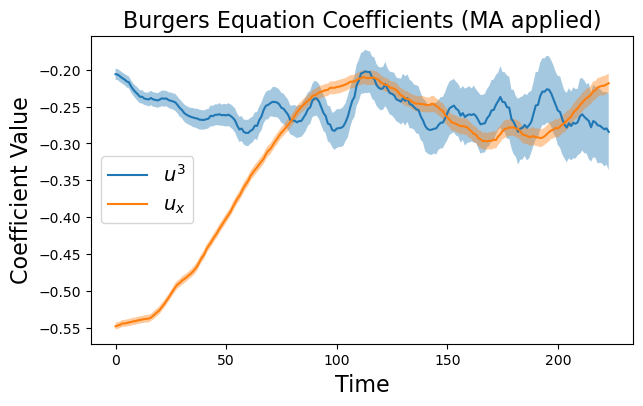

In [71]:
xi = xi_ma
remain = remain_ma
std = std_ma
wt2 = int(wt+(window-1)/2)

xi_bglss = np.zeros(xi_true[:,wt2:-wt2].shape)

pylab.rcParams['figure.figsize'] = (7, 4)
fig, ax = plt.subplots()
for j in range(xi.shape[0]): 
    if np.linalg.norm(xi[j,:]) > 10**-10:
        plot(xi[j,:], label = r'$'+rhs_des[remain[j]]+r'$')
        fill_between(range(len(xi[j,:])), xi[j,:]-std[j, :], xi[j,:]+std[j, :], alpha=0.4)
        xi_bglss[remain[j], :] = xi[j,:]

title('Burgers Equation Coefficients (MA applied)', fontsize = 16)
xlabel('Time', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', fontsize = 14)

mse_ma_bglss = Norm(xi_bglss-xi_true[:,wt2:-wt2])**2/(m3*len(rhs_des))
print('MSE: ', mse_ma_bglss)
plt.show()
fig.savefig("tbglss-ma.png", dpi=200)